### Import Libraries

In [1]:
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input,Dense, Embedding
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.layers import Flatten,Concatenate,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Make Directory Structure

In [2]:
!mkdir Saved_Models

### Load dataset

In [3]:
data = pd.read_csv('../input/msk-impact-basic/processed_data.csv')

### Drop Unnecessary Columns

In [4]:
data = data.drop(['TissueAge_yrs',\
                  'AssayPerformance',\
                  'SpecimenType'],axis=1)

In [5]:
data.shape

(8121, 34)

In [6]:
data.head(2)

,SAMPLE_ID,SAMPLE_COLLECTION_SOURCE,SPECIMEN_TYPE,SAMPLE_COVERAGE,TUMOR_PURITY,SAMPLE_TYPE,SAMPLE_CLASS,ONCOTREE_CODE,CANCER_TYPE_DETAILED,SOMATIC_STATUS,...,MetastasisSite,TumorTypeCode,ExonicMutationCount,SNVCount,INDELCount,SCNACount,SVCount,SilentMutationCount,N,Cancer_Type
0,P-0000023-T01-IM3,In-House,Biopsy,454,30.0,Primary,Tumor,PEMESO,Peritoneal Mesothelioma,Matched,...,Not Applicable,PEMESO,5,3,2,1,0,0,18,Mesothelioma
1,P-0001126-T01-IM3,In-House,Resection,574,30.0,Metastasis,Tumor,PEMESO,Peritoneal Mesothelioma,Matched,...,Bowel,PEMESO,2,1,1,1,0,1,18,Mesothelioma


#### Convert Binary Target Variable to Numeric

In [7]:
data['SAMPLE_TYPE'].replace(['Primary', 'Metastasis'],[0, 1], inplace=True)

In [8]:
data.head(2)

,SAMPLE_ID,SAMPLE_COLLECTION_SOURCE,SPECIMEN_TYPE,SAMPLE_COVERAGE,TUMOR_PURITY,SAMPLE_TYPE,SAMPLE_CLASS,ONCOTREE_CODE,CANCER_TYPE_DETAILED,SOMATIC_STATUS,...,MetastasisSite,TumorTypeCode,ExonicMutationCount,SNVCount,INDELCount,SCNACount,SVCount,SilentMutationCount,N,Cancer_Type
0,P-0000023-T01-IM3,In-House,Biopsy,454,30.0,0,Tumor,PEMESO,Peritoneal Mesothelioma,Matched,...,Not Applicable,PEMESO,5,3,2,1,0,0,18,Mesothelioma
1,P-0001126-T01-IM3,In-House,Resection,574,30.0,1,Tumor,PEMESO,Peritoneal Mesothelioma,Matched,...,Bowel,PEMESO,2,1,1,1,0,1,18,Mesothelioma


### Convert Categorical Data Columns to Numerical

In [9]:
data['SPECIMEN_TYPE'].replace(['Resection', 'Biopsy','Cytology','CUSA'],[0, 1, 2, 3], inplace=True)
data['SOMATIC_STATUS'].replace(['Matched', 'Unmatched'],[0, 1], inplace=True)
data['SEX'].replace(['Male', 'Female'],[0, 1], inplace=True)
data['SMOKING_HISTORY'].replace(['Prev/Curr Smoker', 'Never','Unknown'],[0, 1, 2], inplace=True)
data['SampleType'].replace(['FFPE', 'DNA', 'Cell Pellet','FNA', 'Other'],[0, 1, 2, 3, 4], inplace=True)
data['SAMPLE_COLLECTION_SOURCE'].replace(['In-House','Outside'],[0, 1], inplace=True)
data['VITAL_STATUS'].replace(['ALIVE','DECEASED'],[0, 1], inplace=True)

### Try Feature Engineering

In [10]:
sample_ids = data['SAMPLE_ID'].tolist()

In [11]:
data_mutations = pd.read_csv('../input/msk-impact-basic/data_mutations.txt',\
                             sep='\t',\
                             skiprows=1,\
                             low_memory=False)

In [12]:
t_ref_counts = []
t_alt_counts = []
protein_poss = []
codon_counts = []
pos_diffs = []
for sample_id in tqdm(sample_ids):
    segment = data_mutations[data_mutations['Tumor_Sample_Barcode']==sample_id]
    pos_diff = segment['End_Position']- segment['Start_Position']
    pos_diff = np.sum(pos_diff)
    codons  = segment['Codons'].values
    codons = [x for x in codons if str(x) != 'nan']
    t_ref = np.mean(segment['t_ref_count'])
    t_alt = np.mean(segment['t_alt_count'])
    protein_pos = np.mean(segment['Protein_position'])
    t_ref_counts.append(t_ref) 
    t_alt_counts.append(t_alt) 
    protein_poss.append(protein_pos)
    codon_counts.append(len(codons))
    pos_diffs.append(pos_diff)

100%|██████████| 8121/8121 [00:54<00:00, 150.30it/s]


### Add New Features to Dataset

In [13]:
data['t_ref_counts'] = t_ref_counts
data['t_alt_counts'] = t_alt_counts
data['protein_pos'] = protein_poss
data['codon_counts'] = codon_counts
data['pos_diffs'] = pos_diffs

### Separate Features and Labels

In [14]:
X = data.drop(['SAMPLE_TYPE'], axis=1)
y = data['SAMPLE_TYPE']

### Train and Validation Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45, stratify=y)

### Create A Dataframe with only Numerical Features

In [16]:
numericalFeats = X.select_dtypes(include=[np.number]).columns

X_train_num = X_train[numericalFeats]
X_train_num = X_train_num.fillna(X_train_num.mean())
standard_scaler = StandardScaler()
X_train_num = standard_scaler.fit_transform(X_train_num)

X_test_num = X_test[numericalFeats]
X_test_num = X_test_num.fillna(X_test_num.mean())
standard_scaler = StandardScaler()
X_test_num = standard_scaler.fit_transform(X_test_num)

### Set Training Parameter Settings

In [17]:
epochs = 30
batch_size = 64
learning_rate = 0.01
num_classes = 2

### Define Custom Callbacks

In [18]:
# Callback code for Early stopping
class EarlyStopper(Callback):
    def __init__(self, target):
        super(EarlyStopper, self).__init__()
        self.target = target
    def on_epoch_end(self, epoch, logs={}):
        acc = logs['val_accuracy']
        if acc >= self.target:
            self.model.stop_training = True

In [19]:
# Callback for micro-f1 score
class LossHistory(tf.keras.callbacks.Callback):
    
    def __init__(self,validation_data):
        self.x_test = validation_data[0]
        self.y_test= validation_data[1]
        
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [],'val_f1': []}
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
      
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
       
        y_pred= self.model.predict(self.x_test)
        y_label_pred=np.argmax(y_pred,axis=1)
        y_test_arg = self.y_test
        
        F1 = f1_score(y_test_arg, y_label_pred, average='micro')
        self.history['val_f1'].append(F1)
        print(' Val F1 Score : ', np.round(F1,4))

### Initialize Optimizers

In [20]:
adamopt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

### Define Model 1 Architecture

In [21]:
model_1 = Sequential()

model_1.add(Dense(64,\
                input_shape=(X_train_num.shape[1],), \
                activation='relu'))

model_1.add(Dense(128,\
                kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                activation=tf.nn.relu))

model_1.add(Dense (128,\
                 activation = 'relu'))

model_1.add(Dense (64,\
                 activation = 'relu'))

model_1.add(Dense(32,\
                activation='relu'))

model_1.add(Dense(2,\
                activation='softmax'))

2022-10-30 16:21:44.205675: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Initialize History Callback

In [22]:
history_callback_1 = LossHistory(validation_data=([X_test_num, y_test]))  

### Model Persistence

In [23]:
filepath_1= "./Saved_Models/best_model_1.hdf5"
checkpoint_1 = ModelCheckpoint(filepath=filepath_1, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

### TensorBoard Setup

In [24]:
log_dir_1 = os.path.join("logs",'fits','Model_1')
tfcb_1 = TensorBoard(log_dir=log_dir_1,histogram_freq=1,write_graph=True)

2022-10-30 16:21:44.892255: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-30 16:21:44.892582: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-30 16:21:44.893675: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### Model 1 Compilation

In [25]:
model_1.compile(optimizer=adamopt,\
              loss = tf.keras.losses.sparse_categorical_crossentropy,\
              metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 36,834
Trainable params: 36,834
Non-trainable params: 0
____________________________________________________

### Visualize Model 1 Architecture

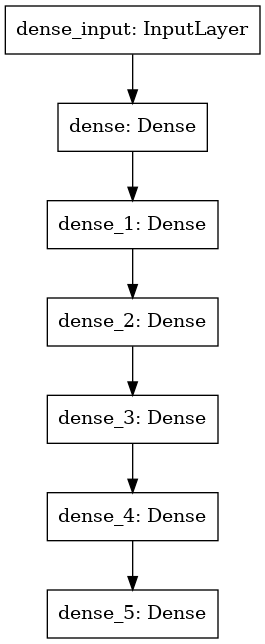

In [26]:
plot_model(model_1)

In [27]:
mycallbacks_1 = [history_callback_1,\
                 checkpoint_1,\
                 tfcb_1]

### Model 1 Training

In [28]:
history_1 = model_1.fit(x=X_train_num,\
                        y=y_train,\
                        batch_size=batch_size,\
                        epochs=epochs,\
                        steps_per_epoch = int(np.ceil(X_train_num.shape[0] / batch_size) ),\
                        validation_data=(X_test_num, y_test),\
                        callbacks=mycallbacks_1)

2022-10-30 16:21:46.831819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
36/89 [===========>..................] - ETA: 0s - loss: 0.6751 - accuracy: 0.5864

2022-10-30 16:21:47.646487: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-30 16:21:47.646683: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-30 16:21:47.655078: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-30 16:21:47.661564: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-30 16:21:47.673043: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fits/Model_1/train/plugins/profile/2022_10_30_16_21_47

2022-10-30 16:21:47.674327: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fits/Model_1/train/plugins/profile/2022_10_30_16_21_47/1be5dcaa276b.trace.json.gz
2022-10-30 16:21:47.688087: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fits/Model_1/train/plugins/profile/2022_10_30_

89/89 [==============================] - 1s 7ms/step - loss: 0.6471 - accuracy: 0.6272 - val_loss: 0.6586 - val_accuracy: 0.6332
 Val F1 Score :  0.6332

Epoch 00001: val_accuracy improved from -inf to 0.63316, saving model to ./Saved_Models/best_model_1.hdf5
Epoch 2/30
89/89 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6571 - val_loss: 0.6239 - val_accuracy: 0.6627
 Val F1 Score :  0.6627

Epoch 00002: val_accuracy improved from 0.63316 to 0.66270, saving model to ./Saved_Models/best_model_1.hdf5
Epoch 3/30
89/89 [==============================] - 0s 4ms/step - loss: 0.6164 - accuracy: 0.6638 - val_loss: 0.6272 - val_accuracy: 0.6524
 Val F1 Score :  0.6524

Epoch 00003: val_accuracy did not improve from 0.66270
Epoch 4/30
89/89 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.6738 - val_loss: 0.6215 - val_accuracy: 0.6529
 Val F1 Score :  0.6529

Epoch 00004: val_accuracy did not improve from 0.66270
Epoch 5/30
89/89 [========

### Define Model 2 Architecture

In [29]:
model_2 = Sequential()

model_2.add(Dense(32,\
                  kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                  input_shape=(X_train_num.shape[1],),\
                  activation='relu'))

model_2.add(Dense(64,\
                  kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                  activation=tf.nn.relu))

model_2.add(Dense (128,\
                   kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                   activation = 'relu'))

model_2.add(Dense (256,\
                   kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                   activation = 'relu'))

model_2.add(Dense (512,\
                   kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                   activation = 'relu'))

model_2.add(Dense(128,\
                  kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                  activation='relu'))

model_2.add(Dense(64,\
                  kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                  activation='relu'))

model_2.add(Dense(2,\
                activation='softmax'))

### Model 2 Persistence

In [30]:
filepath_2= "./Saved_Models/best_model_2.hdf5"
checkpoint_2 = ModelCheckpoint(filepath=filepath_2, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

### Tensorboard Setup

In [31]:
log_dir_2 = os.path.join("logs",'fits','Model_2')
tfcb_2 = TensorBoard(log_dir=log_dir_2,histogram_freq=1,write_graph=True)

2022-10-30 16:22:06.407472: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-30 16:22:06.407528: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-30 16:22:06.408125: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### Model 2 Compilation

In [32]:
model_2.compile(optimizer=adamopt,\
              loss = tf.keras.losses.sparse_categorical_crossentropy,\
              metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

### Visualize Model 2 Architecture

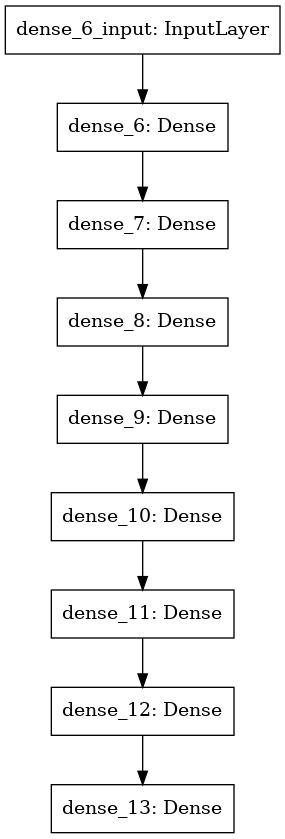

In [33]:
plot_model(model_2)

### Join Model 2 Callbacks

In [34]:
mycallbacks_2 = [history_callback_1,\
                 checkpoint_2,\
                 tfcb_2]

### Model 2 Training

In [35]:
history_2 = model_2.fit(x=X_train_num,\
                        y=y_train,\
                        batch_size=batch_size,\
                        epochs=epochs,\
                        steps_per_epoch = int(np.ceil(X_train_num.shape[0] / batch_size) ),\
                        validation_data=(X_test_num, y_test),\
                        callbacks=mycallbacks_2)

Epoch 1/30
24/89 [=======>......................] - ETA: 0s - loss: 0.6960 - accuracy: 0.5638

2022-10-30 16:22:08.292265: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-30 16:22:08.292673: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-30 16:22:08.344377: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-30 16:22:08.345934: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-30 16:22:08.347975: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fits/Model_2/train/plugins/profile/2022_10_30_16_22_08

2022-10-30 16:22:08.349261: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fits/Model_2/train/plugins/profile/2022_10_30_16_22_08/1be5dcaa276b.trace.json.gz
2022-10-30 16:22:08.352960: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fits/Model_2/train/plugins/profile/2022_10_30_

89/89 [==============================] - 1s 9ms/step - loss: 0.6896 - accuracy: 0.5753 - val_loss: 0.6805 - val_accuracy: 0.5794
 Val F1 Score :  0.5794

Epoch 00001: val_accuracy improved from -inf to 0.57940, saving model to ./Saved_Models/best_model_2.hdf5
Epoch 2/30
89/89 [==============================] - 1s 6ms/step - loss: 0.6811 - accuracy: 0.5795 - val_loss: 0.6810 - val_accuracy: 0.5794
 Val F1 Score :  0.5794

Epoch 00002: val_accuracy did not improve from 0.57940
Epoch 3/30
89/89 [==============================] - 1s 6ms/step - loss: 0.6809 - accuracy: 0.5795 - val_loss: 0.6807 - val_accuracy: 0.5794
 Val F1 Score :  0.5794

Epoch 00003: val_accuracy did not improve from 0.57940
Epoch 4/30
89/89 [==============================] - 1s 6ms/step - loss: 0.6804 - accuracy: 0.5795 - val_loss: 0.6819 - val_accuracy: 0.5794
 Val F1 Score :  0.5794

Epoch 00004: val_accuracy did not improve from 0.57940
Epoch 5/30
89/89 [==============================] - 1s 6ms/step - loss: 0.6814 -

### Define Model 3 Architechture

#### Model 3 Layer Preparation

In [36]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train['DetailedTumorType'])
X_train_dtumort = tokenizer.texts_to_sequences(X_train['DetailedTumorType'])
X_test_dtumort = tokenizer.texts_to_sequences(X_test['DetailedTumorType'])
X_train_dtumort = pad_sequences(X_train_dtumort, dtype='uint8')
X_test_dtumort = pad_sequences(X_test_dtumort, dtype='uint8')

In [37]:
num_inp = Input(shape=X_train_num.shape[1], name='input_remaining')
num_dense = Dense(8, activation='relu', name='numerical_features')(num_inp)

dtumort_inp = Input(shape=11, name='detailed_tumor_type')
dtumort_inp_emb = Embedding(input_dim=X_train_dtumort.max() + 1,\
                            output_dim=10,\
                            input_length=5,\
                            name='Emb_detailed_tumor_type')(dtumort_inp)
dtumort_flat = Flatten(name='dtumort_flatten_1')(dtumort_inp_emb )

In [38]:
concat_layer = Concatenate(name='Concatenate')([num_dense,\
                                                dtumort_flat])

dense_1 = Dense(256,\
                activation='relu',\
                kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                name='Dense_layer1_after_concat')(concat_layer)

drop_1 = Dropout(0.2, name='dropout_1')(dense_1)

dense_2 = Dense(128,\
                activation='relu',\
                kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                name='Dense_layer2_after_concat')(drop_1)

drop_2 = Dropout(0.15, name='dropout_2')(dense_2)

dense_3 = Dense(64,\
                kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),\
                activation='relu',\
                name='Dense_layer3_after_concat')(drop_2)

output_layer = Dense(2, activation='softmax',name='output_layer')(dense_3)

In [39]:
model_3 = Model(inputs=[num_inp,\
                        dtumort_inp],\
               outputs=output_layer)

In [40]:
X_train_emb = [X_train_num,\
               X_train_dtumort]

X_test_emb = [X_test_num,\
              X_test_dtumort]

### Initialize Model 3 Callbacks

In [41]:
history_callback_3 = LossHistory(validation_data=([X_test_emb, y_test]))  

stopperCallback3 = EarlyStopper(0.9501)

log_dir_3 = os.path.join("logs",'fits','Model_3')
tfcb_3 = TensorBoard(log_dir=log_dir_3,histogram_freq=1,write_graph=True)

filepath_3= "./Saved_Models/best_model_3.hdf5"
checkpoint_3 = ModelCheckpoint(filepath=filepath_3, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

2022-10-30 16:22:35.501008: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-30 16:22:35.501066: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-30 16:22:35.501157: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [42]:
mycallbacks_3 = [stopperCallback3,\
                 history_callback_3,\
                 checkpoint_3,\
                 tfcb_3]

### Compile Model 3

In [43]:
model_3.compile(optimizer=adamopt,\
                loss = tf.keras.losses.sparse_categorical_crossentropy,\
                metrics=['accuracy'])

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
detailed_tumor_type (InputLayer [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_remaining (InputLayer)    [(None, 24)]         0                                            
__________________________________________________________________________________________________
Emb_detailed_tumor_type (Embedd (None, 11, 10)       2560        detailed_tumor_type[0][0]        
__________________________________________________________________________________________________
numerical_features (Dense)      (None, 8)            200         input_remaining[0][0]            
______________________________________________________________________________________________

### Visualize Model 3 Architecture

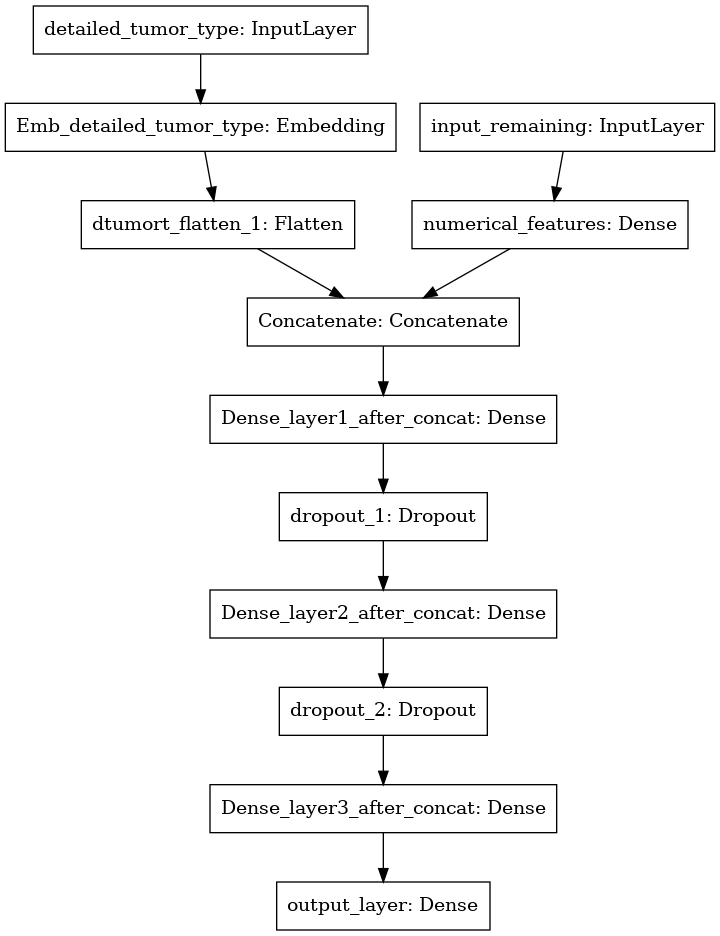

In [44]:
plot_model(model_3)

### Train Model 3

In [45]:
history_3 = model_3.fit(x = X_train_emb,\
                        y = y_train,\
                        batch_size=batch_size,\
                        epochs=epochs,\
                        steps_per_epoch = int(np.ceil(X_train_emb[0].shape[0] / batch_size) ),\
                        validation_data=(X_test_emb, y_test),\
                        callbacks=mycallbacks_3)

Epoch 1/30
32/89 [=========>....................] - ETA: 0s - loss: 0.7679 - accuracy: 0.5610

2022-10-30 16:22:37.638206: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-30 16:22:37.638263: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-30 16:22:37.689824: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-30 16:22:37.691694: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-30 16:22:37.694026: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fits/Model_3/train/plugins/profile/2022_10_30_16_22_37

2022-10-30 16:22:37.695425: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fits/Model_3/train/plugins/profile/2022_10_30_16_22_37/1be5dcaa276b.trace.json.gz
2022-10-30 16:22:37.699054: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fits/Model_3/train/plugins/profile/2022_10_30_

89/89 [==============================] - 1s 8ms/step - loss: 0.6909 - accuracy: 0.5996 - val_loss: 0.6015 - val_accuracy: 0.6627
 Val F1 Score :  0.6627

Epoch 00001: val_accuracy improved from -inf to 0.66270, saving model to ./Saved_Models/best_model_3.hdf5
Epoch 2/30
89/89 [==============================] - 0s 5ms/step - loss: 0.6103 - accuracy: 0.6575 - val_loss: 0.5937 - val_accuracy: 0.6660
 Val F1 Score :  0.666

Epoch 00002: val_accuracy improved from 0.66270 to 0.66598, saving model to ./Saved_Models/best_model_3.hdf5
Epoch 3/30
89/89 [==============================] - 0s 5ms/step - loss: 0.5809 - accuracy: 0.6944 - val_loss: 0.5850 - val_accuracy: 0.6799
 Val F1 Score :  0.6799

Epoch 00003: val_accuracy improved from 0.66598 to 0.67993, saving model to ./Saved_Models/best_model_3.hdf5
Epoch 4/30
89/89 [==============================] - 0s 4ms/step - loss: 0.5487 - accuracy: 0.7203 - val_loss: 0.5586 - val_accuracy: 0.7050
 Val F1 Score :  0.705

Epoch 00004: val_accuracy imp

### Plot the train and test loss graph of all models

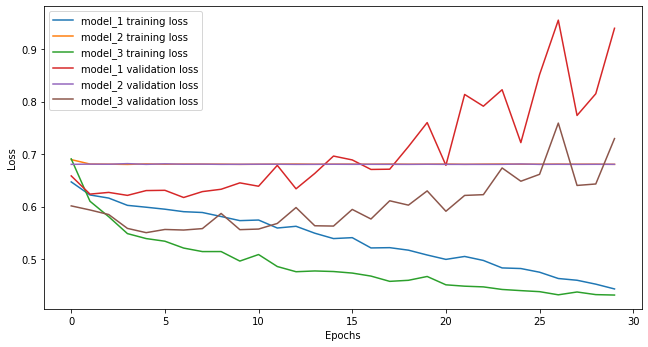

In [46]:
fig1, ax = plt.subplots(figsize=(10,6))
fig1.subplots_adjust(left=.16, bottom=.2, right=.99, top=.90)
plt.plot(history_1.history['loss'], label='model_1 training loss')
plt.plot(history_2.history['loss'], label='model_2 training loss')
plt.plot(history_3.history['loss'], label='model_3 training loss')
plt.plot(history_1.history['val_loss'], label='model_1 validation loss')
plt.plot(history_2.history['val_loss'], label='model_2 validation loss')
plt.plot(history_3.history['val_loss'], label='model_3 validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### TensorBoard Visualization

In [47]:
# Load Tensor Board
%load_ext tensorboard
%tensorboard --logdir logs/fits

### Summary

| **No** | **Model** |                    **Description**                   | **Validation Accuracy** |
|:------:|:---------:|:----------------------------------------------------:|:-----------------------:|
|      1 |     DNN 1 | DNN with numerical features only                     |                 0.66270 |
|      2 |     DNN 2 | DNN with numerical features  and more layers         |                 0.57940 |
|      3 |     DNN 3 | DNN with numerical features  and categorical feature |                 0.73492 |